# What can this package do?

https://juliaai.github.io/MLJ.jl/stable/model_browser/

# Important Note:
Machine Learning is just a single or serveral advanced algorithms compiled to simulate learning. The most important part of Machine Learning is your data. You need properly labeled data, often large amounts of data, high quality data, and selecting data relevent to your result to train your neural network on.

# My example: AI Image Classification

In [1]:
using CSV, DataFrames, FileIO, Images, MLJ, ProgressBars, Flux, IJulia, Random
import MLJFlux
import Optimisers
import MLJIteration # for `skip` control

In [2]:
function classify(ai::Int, real::Int)
    if ai == 1
        return "ai"
    elseif real == 1
        return "real"
    else
        return "unknown"  # You can also filter these out
    end
end

function load_image_safe(path)
    try
        return Images.load(path)
    catch e
        @warn "Could not load $path" exception=e
        return missing
    end
end

function make_input(path)
    
    training_path = path * "_classes.csv"
    labels_df = CSV.read(training_path, DataFrame)
   
    labels_df.label = classify.(labels_df.ai_generated, labels_df.real)
   
    labels_df.image_path = path .* labels_df.filename
    
    labels_df.image = [load_image_safe(paths) for paths in labels_df.image_path]
    filter!(row -> row.image !== missing, labels_df);
   
    # Coerce label into categorical
    labels_df.label = coerce(labels_df.label, Multiclass)

    # Features and Target
    x = labels_df.image
    y = labels_df.label;
   
    return x,y
end

make_input (generic function with 1 method)

In [15]:
X, y = make_input("Ai-Image-Dataset/train/")

(Matrix{RGB{N0f8}}[[RGB(0.31, 0.251, 0.169) RGB(0.306, 0.247, 0.165) … RGB(0.298, 0.243, 0.141) RGB(0.302, 0.247, 0.145); RGB(0.267, 0.208, 0.125) RGB(0.302, 0.243, 0.161) … RGB(0.298, 0.243, 0.141) RGB(0.298, 0.243, 0.141); … ; RGB(0.169, 0.196, 0.133) RGB(0.169, 0.196, 0.133) … RGB(0.196, 0.298, 0.976) RGB(0.176, 0.314, 0.965); RGB(0.18, 0.208, 0.145) RGB(0.18, 0.208, 0.145) … RGB(0.176, 0.314, 0.965) RGB(0.149, 0.329, 0.949)], [RGB(0.165, 0.18, 0.09) RGB(0.165, 0.18, 0.09) … RGB(0.192, 0.212, 0.094) RGB(0.192, 0.212, 0.094); RGB(0.165, 0.18, 0.09) RGB(0.165, 0.18, 0.09) … RGB(0.192, 0.212, 0.094) RGB(0.192, 0.212, 0.094); … ; RGB(0.008, 0.008, 0.008) RGB(0.008, 0.008, 0.008) … RGB(0.051, 0.059, 0.039) RGB(0.051, 0.059, 0.039); RGB(0.008, 0.008, 0.008) RGB(0.008, 0.008, 0.008) … RGB(0.051, 0.059, 0.039) RGB(0.051, 0.059, 0.039)], [RGB(0.149, 0.259, 0.443) RGB(0.157, 0.267, 0.451) … RGB(0.027, 0.027, 0.027) RGB(0.027, 0.027, 0.027); RGB(0.153, 0.263, 0.447) RGB(0.157, 0.267, 0.451) … 

In [3]:
import MLJFlux

struct MyConvBuilder
    filter_size::Int
    channels1::Int
    channels2::Int
    channels3::Int
end

make2d(x::AbstractArray) = reshape(x, :, size(x)[end])

function MLJFlux.build(b::MyConvBuilder, rng, n_in, n_out, n_channels)
    k, c1, c2, c3 = b.filter_size, b.channels1, b.channels2, b.channels3
    mod(k, 2) == 1 || error("`filter_size` must be odd. ")
    p = div(k - 1, 2) # padding to preserve image size
    init = Flux.glorot_uniform(rng)
    front = Chain(
        Conv((k, k), n_channels => c1, pad=(p, p), relu, init=init),
        MaxPool((2, 2)),
        Conv((k, k), c1 => c2, pad=(p, p), relu, init=init),
        MaxPool((2, 2)),
        Conv((k, k), c2 => c3, pad=(p, p), relu, init=init),
        MaxPool((2 ,2)),
        make2d)
    d = Flux.outputsize(front, (n_in..., n_channels, 1)) |> first
    return Chain(front, Dense(d, n_out, init=init))
end

In [42]:
#using CUDA
#using cuDNN
#import oneAPI

In [4]:
ImageClassifier = @load ImageClassifier pkg=MLJFlux
clf = ImageClassifier(builder=MyConvBuilder(3, 16, 32, 32),
                      #acceleration=CUDALibs(),
                      batch_size=40,
                      epochs=50,
                      rng=123
                      )


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\carte\.julia\packages\MLJModels\nxeCf\src\loading.jl:159


import MLJFlux ✔


ImageClassifier(
  builder = MyConvBuilder(3, 16, 32, 32), 
  finaliser = NNlib.softmax, 
  optimiser = Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), 
  loss = Flux.Losses.crossentropy, 
  epochs = 50, 
  batch_size = 40, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = 123, 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

In [7]:
mach = machine(clf, X, y);
fit!(mach, rows=1:6500, verbosity=2);
report(mach)
Flux.trainable(mach)

┌ Info: Training machine(ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …), …).
└ @ MLJBase C:\Users\carte\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Loss is 0.6308
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.225
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.1385
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.08726
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.08528
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.07494
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.04212
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.03173
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.02948
└ @ MLJFlux C:\Users\carte\.julia\pack

(model = ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …),
 old_model = ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …),
 fitresult = (Chain(Chain(Chain(Conv((3, 3), 3 => 16, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 16 => 32, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 32 => 32, relu, pad=1), MaxPool((2, 2)), make2d), Dense(204800 => 2)), softmax), CategoricalArrays.CategoricalValue{String, UInt32}["ai", "real"]),
 cache = (ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …), (Array{Float32, 4}[[0.30980393 0.30588236 … 0.29803923 0.3019608; 0.26666668 0.3019608 … 0.29803923 0.29803923; … ; 0.16862746 0.16862746 … 0.19607843 0.1764706; 0.18039216 0.18039216 … 0.1764706 0.14901961;;; 0.2509804 0.24705882 … 0.24313726 0.24705882; 0.20784314 0.24313726 … 0.24313726 0.24313726; … ; 0.19607843 0.19607843 … 0.29803923 0.3137255; 0.20784314 0.20784314 … 0.3137255 0.32941177;;; 0.16862746 0.16470589 … 0.14117648 0.14509805; 0.1254902 0.16078432 … 0.14117648 0.1411

In [ ]:
#Saves our pretrained neural network
#MLJ.save("ai_2.jls", mach)

In [ ]:
mach = machine(clf, X, y);
fit!(mach, rows=3000:6000, verbosity=2);
report(mach)
Flux.trainable(mach)
#MLJ.save("ai_3.jls", mach)

┌ Info: Training machine(ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …), …).
└ @ MLJBase C:\Users\carte\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Loss is 0.667
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.3862
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.199
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.1203
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151
┌ Info: Loss is 0.09139
└ @ MLJFlux C:\Users\carte\.julia\packages\MLJFlux\gyaT3\src\core.jl:151


In [5]:
#Saves our pretrained neural network
#MLJ.save("ai_neural_network.jls", mach)

#Loads our saved neural network
mach = machine("ai_2.jls")

trained Machine; caches model-specific representations of data
  model: ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …)
  args: 


In [6]:

xNew, yNew = make_input("Ai-Image-Dataset/test/")

(Matrix{RGB{N0f8}}[[RGB(0.765, 0.773, 0.678) RGB(0.769, 0.776, 0.682) … RGB(0.322, 0.208, 0.184) RGB(0.318, 0.204, 0.18); RGB(0.761, 0.769, 0.675) RGB(0.765, 0.773, 0.678) … RGB(0.322, 0.208, 0.184) RGB(0.322, 0.208, 0.184); … ; RGB(0.984, 0.976, 0.925) RGB(0.984, 0.976, 0.925) … RGB(0.404, 0.431, 0.369) RGB(0.38, 0.408, 0.345); RGB(0.969, 0.961, 0.91) RGB(0.969, 0.961, 0.91) … RGB(0.416, 0.443, 0.38) RGB(0.396, 0.424, 0.361)], [RGB(0.631, 0.655, 0.639) RGB(0.627, 0.651, 0.635) … RGB(0.627, 0.667, 0.635) RGB(0.627, 0.667, 0.635); RGB(0.639, 0.663, 0.647) RGB(0.635, 0.659, 0.643) … RGB(0.631, 0.671, 0.639) RGB(0.631, 0.671, 0.639); … ; RGB(0.765, 0.792, 0.765) RGB(0.765, 0.792, 0.765) … RGB(0.231, 0.282, 0.976) RGB(0.208, 0.294, 0.969); RGB(0.765, 0.792, 0.765) RGB(0.765, 0.792, 0.765) … RGB(0.208, 0.286, 1.0) RGB(0.18, 0.302, 0.992)], [RGB(0.027, 0.082, 0.275) RGB(0.027, 0.082, 0.275) … RGB(0.094, 0.075, 0.059) RGB(0.098, 0.078, 0.063); RGB(0.027, 0.082, 0.275) RGB(0.027, 0.082, 0.275)

In [ ]:

yhat = predict(mach,xNew)

In [ ]:
#using JLD2
#JLD2.@save "my_variables.jld2" xNew yhat yNew

In [7]:
using JLD2
JLD2.@load "my_variables.jld2"

2-element Vector{Symbol}:
 :xNew
 :yhat

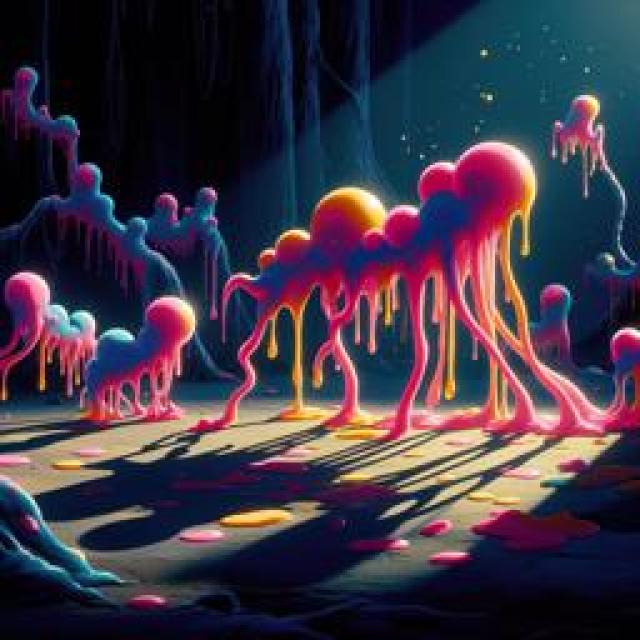

UnivariateFinite{Multiclass{2}}(ai=>1.0, real=>1.0200001e-11)
ai


In [14]:

select = rand(1:size(xNew)[1])
Images.display(xNew[select])
sleep(6)
println(yhat[select])
sleep(2)
println(yNew[select])


    

In [12]:
img = Images.load("shark.jpg")
img_vec = [img]
result = predict(mach,img_vec);

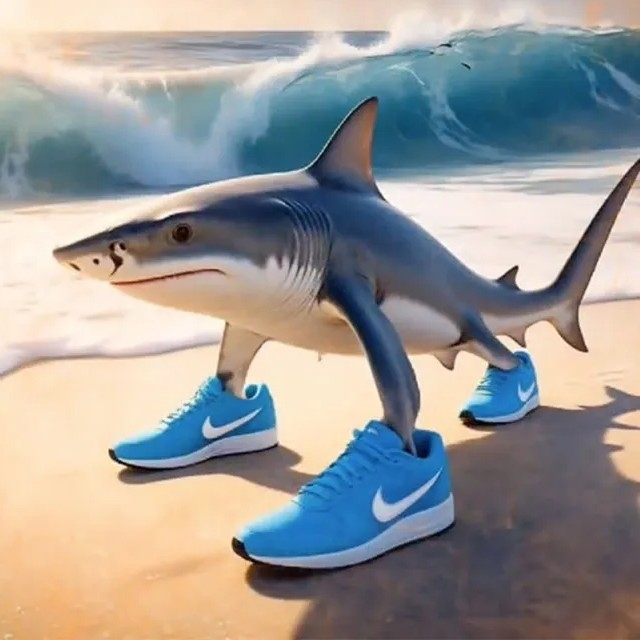

UnivariateFinite{Multiclass{2}, String, UInt32, Float32}[UnivariateFinite{Multiclass{2}}(ai=>1.0, real=>0.000403)]


In [15]:
IJulia.display(img)
println(result)
